<a href="https://colab.research.google.com/github/rguezzdani/Machine-Learning/blob/master/06MBIG_AG3_Optimizaci%C3%B3nDengue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# carga de datos
import pandas as pd
import io
from google.colab import files
# manipulación y visualización
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
from scipy.stats import randint as sp_randint

#sklearn
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

# ensembles
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

# optimization
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Carga y preprocesado

In [0]:
def upload_files ():
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')))
    return df

In [3]:
train_feat = upload_files()
train_feat.head()

Saving dengue_features_train.csv to dengue_features_train.csv
User uploaded file "dengue_features_train.csv" with length 287139 bytes


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [4]:
train_labels = upload_files()
train_labels.head()

Saving dengue_labels_train.csv to dengue_labels_train.csv
User uploaded file "dengue_labels_train.csv" with length 19582 bytes


,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6


In [5]:
train = pd.merge(train_feat,train_labels,on=['city', 'year', 'weekofyear'])
train.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [6]:
test = upload_files()
x_test = test.copy()
test.head()

Saving dengue_features_test.csv to dengue_features_test.csv
User uploaded file "dengue_features_test.csv" with length 82465 bytes


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,2008,18,2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,294.527143,301.1,296.4,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,sj,2008,19,2008-05-06,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,294.395714,300.8,296.7,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,sj,2008,20,2008-05-13,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,299.357143,295.308571,302.2,296.4,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,sj,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,294.402857,303.0,296.9,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,sj,2008,22,2008-05-27,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,294.760000,302.3,297.3,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1


In [7]:
train.drop("week_start_date", axis = 1, inplace = True)
x_test.drop("week_start_date", axis = 1, inplace = True)
train.head()

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [8]:
pd.isnull(train).any()

city                                     False
year                                     False
weekofyear                               False
ndvi_ne                                   True
ndvi_nw                                   True
ndvi_se                                   True
ndvi_sw                                   True
precipitation_amt_mm                      True
reanalysis_air_temp_k                     True
reanalysis_avg_temp_k                     True
reanalysis_dew_point_temp_k               True
reanalysis_max_air_temp_k                 True
reanalysis_min_air_temp_k                 True
reanalysis_precip_amt_kg_per_m2           True
reanalysis_relative_humidity_percent      True
reanalysis_sat_precip_amt_mm              True
reanalysis_specific_humidity_g_per_kg     True
reanalysis_tdtr_k                         True
station_avg_temp_c                        True
station_diur_temp_rng_c                   True
station_max_temp_c                        True
station_min_t

In [9]:
# ffill: propagate last valid observation forward to next valid backfill
# Otra Opción: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html#pandas.DataFrame.interpolate
train.fillna(method='ffill', inplace=True)
pd.isnull(train).any()

city                                     False
year                                     False
weekofyear                               False
ndvi_ne                                  False
ndvi_nw                                  False
ndvi_se                                  False
ndvi_sw                                  False
precipitation_amt_mm                     False
reanalysis_air_temp_k                    False
reanalysis_avg_temp_k                    False
reanalysis_dew_point_temp_k              False
reanalysis_max_air_temp_k                False
reanalysis_min_air_temp_k                False
reanalysis_precip_amt_kg_per_m2          False
reanalysis_relative_humidity_percent     False
reanalysis_sat_precip_amt_mm             False
reanalysis_specific_humidity_g_per_kg    False
reanalysis_tdtr_k                        False
station_avg_temp_c                       False
station_diur_temp_rng_c                  False
station_max_temp_c                       False
station_min_t

In [10]:
x_test.fillna(method='ffill', inplace=True)
pd.isnull(x_test).any()

city                                     False
year                                     False
weekofyear                               False
ndvi_ne                                  False
ndvi_nw                                  False
ndvi_se                                  False
ndvi_sw                                  False
precipitation_amt_mm                     False
reanalysis_air_temp_k                    False
reanalysis_avg_temp_k                    False
reanalysis_dew_point_temp_k              False
reanalysis_max_air_temp_k                False
reanalysis_min_air_temp_k                False
reanalysis_precip_amt_kg_per_m2          False
reanalysis_relative_humidity_percent     False
reanalysis_sat_precip_amt_mm             False
reanalysis_specific_humidity_g_per_kg    False
reanalysis_tdtr_k                        False
station_avg_temp_c                       False
station_diur_temp_rng_c                  False
station_max_temp_c                       False
station_min_t

In [0]:
lb = preprocessing.LabelBinarizer()
train['city_bin'] = lb.fit_transform(train['city'])
x_test['city_bin'] = lb.fit_transform(test['city'])

train.drop(['city'], axis = 1, inplace=True)
x_test.drop(['city'], axis = 1, inplace=True)
train.drop(['year'], axis = 1, inplace=True)
x_test.drop(['year'], axis = 1, inplace=True)

# Selección de características

In [12]:
k = 8
columnas = list(train.drop(['total_cases'], axis=1).columns.values)
seleccionadas = SelectKBest(f_regression, k = k).fit(train.drop(['total_cases'], axis=1), train['total_cases'])
atrib = seleccionadas.get_support()
atributos = [columnas[i] for i in list(atrib.nonzero()[0])]
atributos

['weekofyear',
 'ndvi_se',
 'reanalysis_air_temp_k',
 'reanalysis_min_air_temp_k',
 'reanalysis_tdtr_k',
 'station_diur_temp_rng_c',
 'station_min_temp_c',
 'city_bin']

In [0]:
selected_features = atributos.copy()
selected_features.append('total_cases')

x_train = train[selected_features]

In [14]:
x_test = x_test[atributos]
x_test

,weekofyear,ndvi_se,reanalysis_air_temp_k,reanalysis_min_air_temp_k,reanalysis_tdtr_k,station_diur_temp_rng_c,station_min_temp_c,city_bin
0,18,0.102729,298.492857,296.4,3.128571,7.057143,21.7,1
1,19,0.082043,298.475714,296.7,2.571429,5.557143,22.2,1
2,20,0.151083,299.455714,296.4,4.428571,7.785714,22.8,1
3,21,0.124329,299.690000,296.9,4.342857,6.271429,24.4,1
4,22,0.062267,299.780000,297.3,3.542857,7.085714,23.3,1
...,...,...,...,...,...,...,...,...
411,22,0.280629,297.774286,292.7,10.100000,9.050000,21.8,0
412,23,0.285371,297.167143,291.6,9.657143,10.720000,21.4,0
413,24,0.252586,295.831429,290.7,7.385714,10.075000,21.6,0
414,25,0.406614,295.778571,292.5,8.228571,8.480000,21.8,0


# Conjuntos de modelos con parámetros por defecto

## RandomForest

In [0]:
regressor = RandomForestRegressor(criterion = 'mae', random_state=0) 

regressor.fit(X = x_train.drop(['total_cases'], axis=1), 
                           y = x_train['total_cases'])
y_pred = regressor.predict(X = x_test)

res = np.rint(y_pred)
res = res.astype(int)
res

KeyboardInterrupt: ignored

In [0]:
output = pd.DataFrame({ 'city': test['city'], 'year': test['year'], 'weekofyear': test['weekofyear'], 
                       'total_cases': res})

from google.colab import files

with open('result.csv', 'w') as f:
  output.to_csv(f,  index = False)
  

files.download('result.csv')

output.head()

,city,year,weekofyear,total_cases
0,sj,2008,18,9
1,sj,2008,19,7
2,sj,2008,20,8
3,sj,2008,21,58
4,sj,2008,22,20


Haciendo uso del RandomForest y utilizando los parámetros que vienen por defecto para este algoritmo conseguimos un resultado de 25,6058.

## AdaBoost

In [0]:
regressor = AdaBoostRegressor(DecisionTreeRegressor(criterion='mae', random_state=0))

regressor.fit(X = x_train.drop(['total_cases'], axis=1),y = x_train['total_cases'])
y_pred = regressor.predict(X = x_test)

res = np.rint(y_pred)
res = res.astype(int)
res

array([  6,   7,   9,  13,  18,  10,   6,  10,  18,  18,  20,  18,  22,
        40,  27,  39,  20,  35,  28,  33,  35,  19,  37,  34,  22,  26,
        34,  34,  28,  29,  35,  27,  52,  19,  26,  17,  22,  26,  19,
        18,  21,  21,  22,  22,   7,  23,  11,  11,   4,  15,   6,   8,
         7,  13,  11,   5,  10,   6,  21,  14,  10,  13,  28,  36,  30,
        30,  27,  18,  35,  35,  24,  30,  18,  39,  35,  41,  35,  35,
        35,  47,  19,  39,  27,  29,  28,  37,  17,  17,  21,  17,  15,
        20,  19,  14,  23,  26,  15,  13,   5,   9,   5,   8,   7,   7,
        15,  12,  10,  18,  18,  20,  30,  41,  15,  13,  36,  38,  23,
        16,  36,  36,  23,  73,  82,  83,  16,  43,  64,  76, 101,  70,
        64,  27,  36,  43,  25,  29,  26,  38,  26,  26,  28,  20,  16,
        17,  15,  13,  15,  22,  16,  18,  11,  14,  14,  11,   7,  12,
         6,   9,  10,   9,   9,  29,  23,  17,  59,  83,  21,  20,  16,
        22,  18,  25,  16,  28,  28,  27,  19,  26,  27,  34,  5

In [0]:
output = pd.DataFrame({ 'city': test['city'], 'year': test['year'], 'weekofyear': test['weekofyear'], 
                       'total_cases': res})

from google.colab import files

with open('result.csv', 'w') as f:
  output.to_csv(f,  index = False)
  

files.download('result.csv')

output.head()

,city,year,weekofyear,total_cases
0,sj,2008,18,5
1,sj,2008,19,7
2,sj,2008,20,11
3,sj,2008,21,12
4,sj,2008,22,18


Con este método hemos obtenido un error de 26,7019.

## GradientBoost

In [0]:
regressor = GradientBoostingRegressor(criterion = 'mae', random_state=0)

regressor.fit( X = x_train.drop(['total_cases'], axis=1), y = x_train['total_cases'])
y_pred = regressor.predict(X = x_test)

res = np.rint(y_pred)
res = res.astype(int)
res

array([ 6,  8,  5, 48,  7,  9,  7, 35,  9, 12, 15, 27, 18, 23, 21, 56, 24,
       33, 29, 29, 33, 23, 27, 35, 27, 27, 34, 44, 29, 29, 32, 25, 26, 27,
       19, 17, 14, 22, 18, 19, 14, 15, 16, 15, 10, 21,  8,  8,  8,  8,  8,
       10, 10, 12,  7,  6,  8,  6, 11, 13, 11, 37, 22, 47, 21, 24, 78, 42,
       31, 60, 45, 25, 29, 33, 72, 56, 71, 45, 41, 41, 28, 40, 25, 28, 38,
       42, 21, 21, 15, 16, 14, 13, 21, 13,  9, 12, 11, 11,  8,  8,  8,  7,
        8,  7, 10,  8, 10, 11, 11, 15, 19, 15, 10, 11, 15, 24, 17, 16, 24,
       87, 29, 29, 86, 67, 47, 34, 36, 32, 42, 33, 31, 28, 36, 24, 27, 25,
       25, 22, 20, 23, 87, 20, 25, 21, 15, 15, 11, 14, 17, 12,  9,  8, 11,
        9,  7, 10,  6,  7,  4, 11, 11, 11, 14, 13, 73, 27, 13, 14, 15, 28,
       21, 28, 25, 34, 55, 31, 81, 28, 32, 72, 45, 42, 30, 29, 32, 79, 30,
       24, 23, 41, 24, 27, 23, 25, 25, 23, 20, 16, 13, 13, 12, 13, 10, 10,
       13, 11,  9, 12,  9, 17,  7, 13,  9, 11,  9, 10, 26, 39, 12, 16, 27,
       20, 43, 19, 27, 56

In [0]:
output = pd.DataFrame({ 'city': test['city'], 'year': test['year'], 'weekofyear': test['weekofyear'], 
                       'total_cases': res})

from google.colab import files

with open('result.csv', 'w') as f:
  output.to_csv(f,  index = False)
  

files.download('result.csv')

output.head()

,city,year,weekofyear,total_cases
0,sj,2008,18,6
1,sj,2008,19,8
2,sj,2008,20,5
3,sj,2008,21,48
4,sj,2008,22,7


Y con este último algoritmo, el resultado del error ha sido de 26,5841.

# Conjuntos de modelos aplicando optimización

## RandomForest

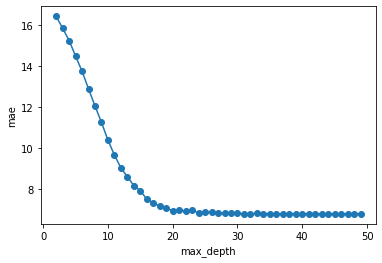

In [0]:
mae = []
for i in range(2, 50):
    regressor = RandomForestRegressor(max_depth=i, criterion='mae', random_state=0)
    regressor.fit(x_train.drop(['total_cases'], axis=1), x_train['total_cases'])
    pred_values = regressor.predict(x_train.drop(['total_cases'], axis=1))
    maev = mean_absolute_error(x_train['total_cases'],pred_values)
    mae.append(maev)
    
plt.plot(range(2,50), mae, marker='o')
plt.xlabel('max_depth')
plt.ylabel('mae')
plt.show()

Como vemos, a partir de una profundidad de 20 se produce una especie de sobreajuste por lo que probaremos con un max_depth entre 2 y 20 en la optimización de los parámetros.

### GridSearchCV

In [0]:
regressor = RandomForestRegressor() 
regressor

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [0]:
def report(results, n_top=3): # Función para mostrar resultados
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [0]:
param_dist = {"n_estimators": [4,8,16,32,64],
  "max_depth": [2,4,6,8,10], 
  "min_samples_split": [2, 4, 6, 8], 
  "min_samples_leaf": [2,4,6,8], 
  "criterion": ['mae'],
  "random_state": [0]
}

In [0]:
grid_regres = GridSearchCV(estimator = regressor, param_grid= param_dist, cv = 10)

# Fit the random search model
grid_regres.fit(X = x_train.drop(['total_cases'], axis=1), 
                           y = x_train['total_cases'])

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_j

In [0]:
report(grid_regres.cv_results_, n_top = 5)

Model with rank: 1
Mean validation score: -0.030 (std: 0.218)
Parameters: {'criterion': 'mae', 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 16, 'random_state': 0}

Model with rank: 1
Mean validation score: -0.030 (std: 0.218)
Parameters: {'criterion': 'mae', 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 16, 'random_state': 0}

Model with rank: 1
Mean validation score: -0.030 (std: 0.218)
Parameters: {'criterion': 'mae', 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 16, 'random_state': 0}

Model with rank: 1
Mean validation score: -0.030 (std: 0.218)
Parameters: {'criterion': 'mae', 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 16, 'random_state': 0}

Model with rank: 5
Mean validation score: -0.030 (std: 0.220)
Parameters: {'criterion': 'mae', 'max_depth': 2, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 16, 'random_state': 0}

Model with

In [0]:
grid_regres.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                      max_depth=2, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=16, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [0]:
# choose the best
best_grid = grid_regres.best_estimator_

# fit and predict
best_grid.fit( X = x_train.drop(['total_cases'], axis=1), y = x_train['total_cases'])
y_pred = best_grid.predict(X = x_test)

res = np.rint(y_pred)
res = res.astype(int)
res

array([14, 14,  6,  6, 14, 14, 14,  6, 14, 14, 14, 14, 15, 19, 22, 24, 26,
       31, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35,
       35, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 13, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 11, 14, 14, 15, 19, 22, 24,
       26, 31, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35,
       35, 35, 35, 14, 14, 14, 14, 14, 12,  8, 14, 11, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 19,
       22, 24, 26, 31, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35,
       35, 35, 35, 35, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15,
       19, 22, 24, 26, 31, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35,
       35, 35, 35, 35, 35, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       15, 19, 22, 24, 26

In [0]:
output = pd.DataFrame({ 'city': test['city'], 'year': test['year'], 'weekofyear': test['weekofyear'], 
                       'total_cases': res})

from google.colab import files

with open('result.csv', 'w') as f:
  output.to_csv(f,  index = False)
  

files.download('result.csv')

output.head()

,city,year,weekofyear,total_cases
0,sj,2008,18,14
1,sj,2008,19,14
2,sj,2008,20,6
3,sj,2008,21,6
4,sj,2008,22,14


Escogemos el mejor estimador, realizamos las predicciones y subimos el fichero de nuestra predicción a la competición, obteniendo en este caso el error de 27,0048.

### RandomizedSearchCV

In [0]:
param_dist = {"n_estimators": [4,8,16,32,64, 128], 
  "max_depth": sp_randint(2, 20), 
  "min_samples_split": sp_randint(2,50), 
  "min_samples_leaf": range(2, 50), 
  "criterion": ['mae'],
  "random_state": [0]
}


In [0]:
rnd_regres = RandomizedSearchCV(estimator = regressor, param_distributions = param_dist, 
                               n_iter = 100, cv = 5, random_state=0, n_jobs = -1)

# Fit the random search model
rnd_regres.fit(X = x_train.drop(['total_cases'], axis=1), 
                           y = train['total_cases'])

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [0]:
report(rnd_regres.cv_results_, n_top = 5)

Model with rank: 1
Mean validation score: -0.017 (std: 0.189)
Parameters: {'criterion': 'mae', 'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 38, 'n_estimators': 128, 'random_state': 0}

Model with rank: 2
Mean validation score: -0.020 (std: 0.191)
Parameters: {'criterion': 'mae', 'max_depth': 2, 'min_samples_leaf': 13, 'min_samples_split': 36, 'n_estimators': 128, 'random_state': 0}

Model with rank: 3
Mean validation score: -0.021 (std: 0.192)
Parameters: {'criterion': 'mae', 'max_depth': 2, 'min_samples_leaf': 10, 'min_samples_split': 17, 'n_estimators': 128, 'random_state': 0}

Model with rank: 4
Mean validation score: -0.022 (std: 0.190)
Parameters: {'criterion': 'mae', 'max_depth': 2, 'min_samples_leaf': 29, 'min_samples_split': 11, 'n_estimators': 64, 'random_state': 0}

Model with rank: 5
Mean validation score: -0.023 (std: 0.207)
Parameters: {'criterion': 'mae', 'max_depth': 5, 'min_samples_leaf': 41, 'min_samples_split': 11, 'n_estimators': 8, 'random_state': 0}


In [0]:
rnd_regres.best_params_

{'criterion': 'mae',
 'max_depth': 2,
 'min_samples_leaf': 2,
 'min_samples_split': 38,
 'n_estimators': 128,
 'random_state': 0}

El uso de este optimizador sobretodo nos ha servido para saber que quizás con un min_samples_split alto disminuye el error, por lo tanto sería interesante probar valores entorno a 38 con GridSearchCV.


In [0]:
best_random = rnd_regres.best_estimator_
# fit and predict
best_random.fit( X = x_train.drop(['total_cases'], axis=1), y = x_train['total_cases'])
y_pred = best_random.predict(X = x_test)

res = np.rint(y_pred)
res = res.astype(int)
res

array([14, 14,  6,  9, 14, 14, 14,  7, 14, 14, 14, 14, 15, 17, 25, 27, 30,
       33, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
       34, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 12, 14, 14, 15, 17, 25, 27,
       30, 33, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
       34, 34, 34, 14, 14, 14, 14, 14, 12,  8, 14, 12, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 17,
       25, 27, 30, 33, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
       34, 34, 34, 34, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15,
       17, 25, 27, 30, 33, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
       34, 34, 34, 34, 34, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       15, 17, 25, 27, 30

In [0]:
output = pd.DataFrame({ 'city': test['city'], 'year': test['year'], 'weekofyear': test['weekofyear'], 
                       'total_cases': res})

from google.colab import files

with open('result.csv', 'w') as f:
  output.to_csv(f,  index = False)
  

files.download('result.csv')

output.head()

,city,year,weekofyear,total_cases
0,sj,2008,18,14
1,sj,2008,19,14
2,sj,2008,20,6
3,sj,2008,21,9
4,sj,2008,22,14


No obstante, de esta manera hemos obtenido un 26,5000.

## AdaBoost

### GridSearchCV

In [0]:
param_dist = {
 "n_estimators": [8, 32, 64, 128],
 "learning_rate" : [0.01,0.05,0.1],
 "loss" : ['linear', 'square', 'exponential']
 }

grid_ada = GridSearchCV(AdaBoostRegressor(DecisionTreeRegressor(criterion='mae')),
                        param_grid = param_dist, cv=10)

grid_ada.fit(X = x_train.drop(['total_cases'], axis=1),y = x_train['total_cases'])


best_ada = grid_ada.best_estimator_
print (best_ada)
# fit and predict
best_ada.fit( X = x_train.drop(['total_cases'], axis=1), y = train['total_cases'])
y_pred = best_ada.predict(X = x_test)

res = np.rint(y_pred)
res = res.astype(int)
res

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                       criterion='mae',
                                                       max_depth=None,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort='deprecated',
                                                       random_state=None,
                                                       splitter='best'),
               

array([  4,   5,   6,  38,  13,  10,   8,  20,  13,  18,  21,  18,  22,
        40,  27,  43,  21,  38,  71,  23,  35,  21,  51,  34,  24,  30,
        20,  34,  26,  27,  33,  22,  35,  15,  26,  16,  18,  26,  19,
        17,  17,  22,  20,  18,   7,   8,  11,  15,   7,   6,   4,   8,
         6,  10,   5,   3,   5,   6,  13,  14,   9,  18,  33,  36,  33,
        40,  44,  44,  35,  35,  35,  30,  28,  39,  68,  38,  38,  42,
        35,  38,  29,  39,  26,  26,  35,  19,  19,  20,  19,  19,  15,
        38,  19,  14,  12,  13,  21,  10,   8,  10,   6,   5,   7,   6,
        10,   9,   8,  24,  11,  21,  21,  30,  14,  11,  34,  33, 126,
        18,  36,  72,  38,  41,  73,  71,  33,  34,  72, 101,  60,  73,
        65,  23,  36,  34,  35,  29,  27,  17,  22,  19,  23,  19,  14,
        26,  15,  13,  14,  21,  22,  12,   7,  11,  14,  12,   7,  13,
         3,   6,  10,   8,   7,  21,  12,  12,  59,  59,  14,  18,  18,
        25,  18,  27,  20,  28,  28,  21,  38,  29,  21,  43,  5

In [0]:
output = pd.DataFrame({ 'city': test['city'], 'year': test['year'], 'weekofyear': test['weekofyear'], 
                       'total_cases': res})

from google.colab import files

with open('result.csv', 'w') as f:
  output.to_csv(f,  index = False)
  

files.download('result.csv')

output.head()

,city,year,weekofyear,total_cases
0,sj,2008,18,4
1,sj,2008,19,5
2,sj,2008,20,6
3,sj,2008,21,38
4,sj,2008,22,13


Con este algoritmo y mediante esta optimización hemos obtenido un 26,1779, el valor más bajo utilizando optimización.

### RandomizedSearchCV

Como anteriormente con el RandomForest, utilizamos RandomizedSearchCV el cual nos permitirá conocer un poco más en torno a qué valores de ciertos parámetros es mejor probar con GridSearchCV.

Aquí simplemente he modificado el número de árboles, probando valores entre 2 y 128.


In [0]:
param_dist = {
 "n_estimators": sp_randint(2,128),
 "learning_rate" : [0.01,0.05,0.1],
 "loss" : ['linear', 'square', 'exponential']
 }

random_ada = RandomizedSearchCV(AdaBoostRegressor(DecisionTreeRegressor(criterion='mae')),
                        param_distributions = param_dist, cv=5, n_iter=100, random_state=0, n_jobs = -1)

random_ada.fit(X = x_train.drop(['total_cases'], axis=1),y = x_train['total_cases'])


best_ada = random_ada.best_estimator_
print (best_ada)
# fit and predict
best_ada.fit( X = x_train.drop(['total_cases'], axis=1), y = train['total_cases'])
y_pred = best_ada.predict(X = x_test)

res = np.rint(y_pred)
res = res.astype(int)
res

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                       criterion='mae',
                                                       max_depth=None,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort='deprecated',
                                                       random_state=None,
                                                       splitter='best'),
               

array([  4,   6,   8,  14,  19,  10,   6,  14,  14,  17,  30,  31,  17,
        27,  34,  72,  38,  38,  71,  23,  31,  19,  37,  35,  16,  66,
        20,  22,  29,  26,  33,  22,  25,  19,  22,  17,  21,  26,  19,
        17,  18,  21,  21,  18,   6,   7,  11,  15,   8,   5,   3,   7,
         8,  10,   4,   3,  10,   4,  14,  14,  10,  18,  33,  38,  25,
        40,  38,  64,  38,  38,  14,  38,  23,  35,  41,  41,  38,  35,
        32,  20,  29,  39,  29,  22,  10,  26,  17,  22,  15,  15,  14,
        56,  13,  17,  16,  18,  46,  10,   6,   9,   7,   5,   7,   5,
        10,   8,   8,  18,  12,  14,  18,  21,  11,  10,  27,  33,  25,
        18,  36,  83,  40,  73, 106,  71,  26,  34,  48,  48,  39,  73,
        55,  30,  33,  47,  27,  29,  27,  17,  27,  19,  28,  19,  16,
        20,  14,  14,   9,  21,  21,  15,   6,  15,   7,  12,   7,  12,
         3,  13,  15,   6,   7,  16,   7,   7,  59,  59,  10,  21,  17,
        42,  18,  25,  25,  35,  30,  34,  35,  24,  21,  33,  5

In [0]:
output = pd.DataFrame({ 'city': test['city'], 'year': test['year'], 'weekofyear': test['weekofyear'], 
                       'total_cases': res})

from google.colab import files

with open('result.csv', 'w') as f:
  output.to_csv(f,  index = False)
  

files.download('result.csv')

output.head()

,city,year,weekofyear,total_cases
0,sj,2008,18,4
1,sj,2008,19,6
2,sj,2008,20,8
3,sj,2008,21,14
4,sj,2008,22,19


En este caso obtengo que el mejor estimador tiene un n_estimators=28, learning_rate=0.01 y un loss=’linear’. 

Con estos parámetros del mejor estimador he obtenido un 26,2500.

Como vemos, con AdaBoost se obtienen mejores resultados que con otros conjuntos de modelos por lo que sería interesante optimizar también el estimador (DecisionTreeRegressor) ya que actualmente se encuentra con los valores por defecto.


## GradientBoost

### GridSearchCV

In [0]:
param_dist = {
 "n_estimators": [32, 64, 128],
 "learning_rate" : [0.01,0.05,0.1,0.25,0.5],
  "max_features" : ["auto", "sqrt"],
 "loss" : ['ls', 'lad', 'huber', 'quantile'],
 "criterion": ['mae', 'friedman_mse']
 }

grid_gb = GridSearchCV(GradientBoostingRegressor(), param_grid = param_dist, cv=10)

grid_gb.fit(X = x_train.drop(['total_cases'], axis=1),y = x_train['total_cases'])


best_gb = grid_gb.best_estimator_
print (best_gb)
# fit and predict
best_gb.fit( X = x_train.drop(['total_cases'], axis=1), y = x_train['total_cases'])
y_pred = best_gb.predict(X = x_test)

res = np.rint(y_pred)
res = res.astype(int)
res

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='huber',
                          max_depth=3, max_features='auto', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=32,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


array([13, 13,  9, 34, 13, 16, 13, 18, 16, 16, 18, 21, 20, 22, 29, 39, 26,
       30, 33, 29, 32, 29, 32, 33, 30, 27, 32, 34, 33, 29, 32, 25, 31, 28,
       24, 21, 20, 22, 21, 22, 18, 18, 17, 18, 14, 13, 13, 13, 13, 13, 13,
       13, 15, 13, 13, 13, 15, 13, 16, 16, 16, 18, 19, 21, 21, 22, 30, 29,
       31, 30, 37, 26, 31, 33, 33, 33, 30, 32, 32, 33, 27, 39, 29, 29, 33,
       32, 29, 29, 20, 21, 20, 20, 22, 17, 13, 17, 17, 15, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 16, 16, 16, 16, 16, 13, 13, 17, 18, 15, 17, 21,
       45, 29, 28, 51, 33, 30, 33, 31, 31, 35, 32, 32, 30, 33, 27, 31, 25,
       28, 28, 25, 29, 20, 22, 22, 20, 21, 18, 17, 17, 17, 14, 13, 13, 13,
       13, 13, 15, 13, 13, 13, 15, 15, 16, 14, 14, 15, 14, 16, 15, 16, 21,
       22, 22, 24, 29, 28, 32, 33, 30, 32, 34, 35, 37, 30, 29, 33, 33, 30,
       28, 25, 30, 29, 32, 22, 22, 22, 22, 21, 18, 17, 17, 17, 14, 13, 13,
       15, 13, 13, 15, 13, 16, 13, 16, 15, 16, 15, 15, 18, 18, 15, 16, 21,
       21, 22, 26, 28, 31

In [0]:
output = pd.DataFrame({ 'city': test['city'], 'year': test['year'], 'weekofyear': test['weekofyear'], 
                       'total_cases': res})

from google.colab import files

with open('result.csv', 'w') as f:
  output.to_csv(f,  index = False)
  

files.download('result.csv')

output.head()

,city,year,weekofyear,total_cases
0,sj,2008,18,13
1,sj,2008,19,13
2,sj,2008,20,9
3,sj,2008,21,34
4,sj,2008,22,13


El mejor estimador de este algoritmo me da un error de 27,3245.

### RandomizedSearchCV

In [0]:
param_dist = {
 "n_estimators": sp_randint(2,128),
 "learning_rate" : [0.01,0.05,0.1,0.25,0.5],
  "max_features" : ["auto", "sqrt"],
 "loss" : ['ls', 'lad', 'huber', 'quantile'],
 "criterion": ['mae', 'friedman_mse'],
 "min_samples_split" : sp_randint(2,50),
 "min_samples_leaf" : sp_randint(2,50),
 "max_depth": sp_randint(2,20)
 }


grid_gb = RandomizedSearchCV(GradientBoostingRegressor(), param_distributions = param_dist, cv=5, n_iter=100, random_state=0, n_jobs = -1)

grid_gb.fit(X = x_train.drop(['total_cases'], axis=1),y = x_train['total_cases'])


best_gb = grid_gb.best_estimator_
print (best_gb)
# fit and predict
best_gb.fit( X = x_train.drop(['total_cases'], axis=1), y = x_train['total_cases'])
y_pred = best_gb.predict(X = x_test)

res = np.rint(y_pred)
res = res.astype(int)
res

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='mae', init=None,
                          learning_rate=0.01, loss='huber', max_depth=17,
                          max_features='sqrt', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=40, min_samples_split=49,
                          min_weight_fraction_leaf=0.0, n_estimators=95,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


array([12, 13, 12, 13, 14, 15, 12, 14, 17, 20, 21, 19, 21, 23, 25, 26, 24,
       27, 31, 29, 30, 25, 27, 30, 27, 24, 27, 29, 27, 23, 27, 23, 23, 24,
       18, 15, 15, 18, 15, 17, 14, 17, 17, 18, 13, 16, 14, 13, 12, 13, 12,
       13, 13, 13, 14, 14, 13, 11, 17, 17, 16, 16, 24, 23, 24, 23, 24, 26,
       25, 26, 31, 25, 29, 31, 31, 28, 30, 28, 29, 28, 24, 30, 25, 24, 26,
       25, 23, 23, 15, 16, 16, 15, 19, 14, 14, 14, 13, 14, 12, 13, 12, 11,
       12, 11, 15, 12, 13, 19, 16, 18, 22, 22, 16, 16, 22, 23, 18, 17, 23,
       26, 27, 24, 28, 31, 27, 31, 29, 30, 31, 29, 28, 26, 30, 25, 25, 26,
       19, 21, 21, 24, 19, 18, 17, 16, 16, 16, 14, 17, 17, 16, 13, 13, 14,
       13, 12, 13, 11, 14, 13, 14, 16, 18, 18, 16, 19, 18, 19, 18, 19, 22,
       22, 21, 23, 24, 23, 27, 28, 26, 27, 28, 29, 31, 26, 25, 27, 28, 28,
       26, 24, 25, 23, 25, 17, 17, 17, 20, 18, 17, 15, 17, 14, 14, 13, 14,
       15, 14, 11, 14, 12, 18, 14, 19, 14, 14, 15, 19, 22, 22, 20, 19, 20,
       21, 23, 24, 24, 25

In [0]:
output = pd.DataFrame({ 'city': test['city'], 'year': test['year'], 'weekofyear': test['weekofyear'], 
                       'total_cases': res})

from google.colab import files

with open('result.csv', 'w') as f:
  output.to_csv(f,  index = False)
  

files.download('result.csv')

output.head()

,city,year,weekofyear,total_cases
0,sj,2008,18,12
1,sj,2008,19,13
2,sj,2008,20,12
3,sj,2008,21,13
4,sj,2008,22,14


Por último, el resultado obtenido con este optimizador ha sido 27,3221.